C:\Users\human\anaconda3\envs\cleanpy39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
C:\Users\human\anaconda3\envs\cleanpy39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


               date  recon_error_mse  is_anomaly
0  2025-01-04 18:41         0.000018           0
1  2025-01-04 18:41         0.000017           0
2  2025-01-04 18:41         0.000010           0
3  2025-01-04 18:41         0.000089           0
4  2025-01-04 18:41         0.000076           0
               date  recon_error_mse  is_anomaly
0  2025-12-25 14:07         0.000009           0
1  2025-12-25 14:07         0.000011           0
2  2025-12-25 14:07         0.000006           0
3  2025-12-25 14:07         0.000005           0
4  2025-12-25 14:07         0.000006           0


C:\Users\human\anaconda3\envs\cleanpy39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


             date  recon_error_mse  is_anomaly
0  01-04 18:41:48         0.000018           0
1  01-04 18:41:48         0.000017           0
2  01-04 18:41:48         0.000010           0
3  01-04 18:41:48         0.000089           0
4  01-04 18:41:48         0.000076           0


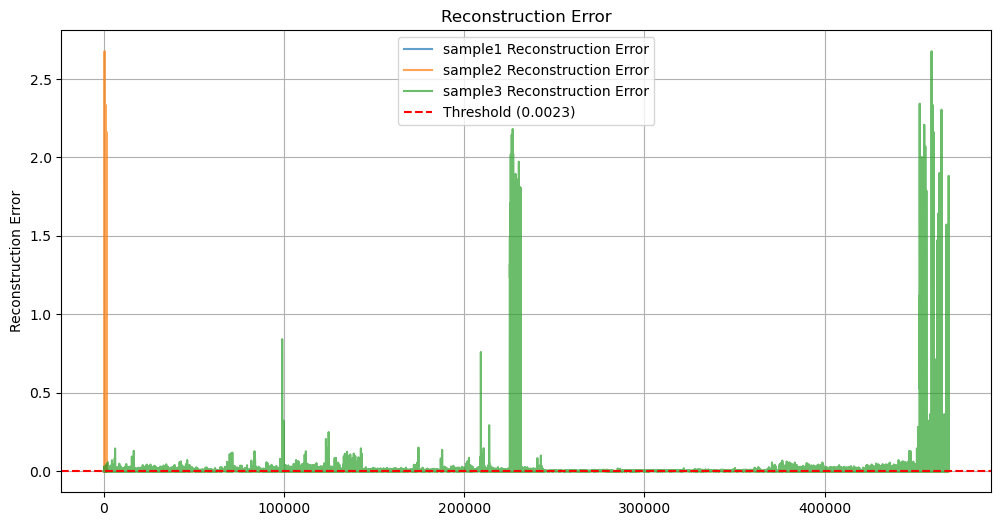

In [52]:
import json
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import pickle 
import joblib
from typing import Optional, Tuple
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 0) 경로 설정 
# ----------------------------------------------------
MODEL_PATH = r"C:\Users\human\Desktop\new_3.9\oneyearmode1\Oneyear_autoencoder_model1.keras"
SCALER_PATH = r"C:\Users\human\Desktop\new_3.9\oneyearmode1\Oneyear_scaler_model1.pkl"   # 또는 scaler.pkl
FEATURES = None
TRAIN_MEDIANS = None
THRESHOLD_INFO = 0.002300092949787481
THR = 0.002300092949787481
# ----------------------------------------------------
# 1) 아티팩트 로드
# ----------------------------------------------------
model = load_model(r"C:\Users\human\Desktop\new_3.9\oneyearmode1\Oneyear_autoencoder_model1.keras")
scaler = joblib.load(r"C:\Users\human\Desktop\new_3.9\oneyearmode1\Oneyear_scaler_model1.pkl")

# ----------------------------------------------------
# 2) 전처리 함수
#   - df_raw: 원본 데이터프레임 (새 데이터)
#   - date_col: 시간 컬럼이 있으면 이름을 넘기면 결과에 같이 반환
# ----------------------------------------------------
def preprocess_for_ae(
    df_raw: pd.DataFrame,
    date_col: Optional[str] = None
) -> Tuple[pd.DataFrame, np.ndarray, Optional[pd.Series]]:
    # 날짜 컬럼 분리(있으면)
    dates: Optional[pd.Series] = None
    df = df_raw.copy()
    if date_col and date_col in df.columns:
        dates = df[date_col].copy()
        df = df.drop(columns=[date_col])

    # FEATURES 순서 고정 (강력 권장)
    if FEATURES is not None:
        # 누락된 컬럼 생성
        missing = [c for c in FEATURES if c not in df.columns]
        for c in missing:
            df[c] = np.nan
        # 불필요한 컬럼 제거
        df = df[FEATURES]

    # 숫자형 변환
    df = df.apply(pd.to_numeric, errors="coerce")

    # 결측치 대체
    if TRAIN_MEDIANS is not None:
        df = df.fillna(TRAIN_MEDIANS.reindex(df.columns))
    else:
        df = df.fillna(df.median(numeric_only=True))

    # 스케일링
    X_scaled = scaler.transform(df.values)

    return df, X_scaled, dates


# ----------------------------------------------------
# 3) reconstruction error 계산 함수 (3.9 호환)
#    metric: "mse" 또는 "mae"
# ----------------------------------------------------
def reconstruction_error(
    X_scaled: np.ndarray,
    metric: str = "mse",
    batch_size: int = 1024
) -> np.ndarray:
    X_hat = model.predict(X_scaled, verbose=0, batch_size=batch_size)
    diff = X_scaled - X_hat
    err = np.mean(np.square(diff), axis=1)
    return err

# ----------------------------------------------------
# 4) 전체 파이프라인: df_raw -> 결과 DataFrame (3.9 호환)
# ----------------------------------------------------
def run_recon(
    df_raw: pd.DataFrame,
    date_col: Optional[str] = None,
    metric: Optional[str] = None
) -> pd.DataFrame:
    # metric 자동 결정: 임계값 파일이 있으면 그 기준에 맞추고, 없으면 "mse"
    if metric is None:
        metric = (THRESHOLD_INFO if THRESHOLD_INFO else "mse") or "mse"

    df_ready, X_scaled, dates = preprocess_for_ae(df_raw, date_col=date_col)
    err = reconstruction_error(X_scaled, metric=metric)

    out = pd.DataFrame({
        "recon_error_mse": err
    }, index=df_ready.index)

    # 임계값 기준 이상치 플래그
    if THRESHOLD_INFO is not None:
        thr = float(THRESHOLD_INFO)
        out["is_anomaly"] = (out.iloc[:, 0].values > thr).astype(int)

    if dates is not None and date_col is not None:
        out.insert(0, date_col, dates.values)
        
    
    return out

# ----------------------------------------------------
# 5) 사용 예시
# ----------------------------------------------------
# 예: 새로운 CSV를 읽어서 date 컬럼 기준으로 결과 내보내기

def simple_preprocess_and_run(csv_path: str):
    drop_cols = [
        "mergedate", "Unnamed: 0",
        "pCut::CTRL_Position_controller::Actual_position",
        "pSvolFilm::CTRL_Position_controller::Actual_position",
        "pSpintor::VAX_speed",
        "blade_id"
    ]
    new_cols = ["date", "timestamp", 'cut torque', 'cut lag error',
                'cut speed', 'film speed', 'film lag error']
    df = pd.read_csv(csv_path)
    df = df.drop(columns=drop_cols, errors="ignore")
    df.columns = new_cols
    # timestamp 제외
    df_for_model = df.drop(["timestamp"], axis=1)
    # run_recon 실행 (외부에 이미 정의되어 있어야 함)
    results = run_recon(df_for_model, date_col="date", metric=None)
    return results, df

results_s1, df_s1 = simple_preprocess_and_run("one_year_mode1_newsample.csv")

print(results_s1.head())

results_s2, df_s2 = simple_preprocess_and_run("one_year_mode1_wornsample.csv")

print(results_s2.head())

results, df = simple_preprocess_and_run("mode1.csv")

print(results.head())

plt.figure(figsize=(12,6))

# Test 데이터
plt.plot(results_s1['recon_error_mse'], label='sample1 Reconstruction Error', alpha=0.7)
plt.plot(results_s2['recon_error_mse'], label='sample2 Reconstruction Error', alpha=0.7)
plt.plot(results['recon_error_mse'], label='sample3 Reconstruction Error', alpha=0.7)

plt.axhline(y=THR, color='r', linestyle='--', label=f'Threshold ({THR:.4f})')

plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
print(results_s1['recon_error_mse'].mean())
print(results_s2['recon_error_mse'].mean())
print(results['recon_error_mse'].mean())

0.00019590015898364766
0.00946640984782718
0.004936863970435743


In [45]:
results[results["is_anomaly"] == 1]

,date,recon_error_mse,is_anomaly
341,2025-01-04 18:41,0.009833,1
342,2025-01-04 18:41,0.006151,1
347,2025-01-04 18:41,0.030129,1
993,2025-01-04 18:41,0.007459,1
994,2025-01-04 18:41,0.004406,1
995,2025-01-04 18:41,0.012276,1
998,2025-01-04 18:41,0.003467,1
999,2025-01-04 18:41,0.031800,1
1000,2025-01-04 18:41,0.009340,1
1651,2025-01-04 18:41,0.009189,1


In [46]:
resultsw[resultsw["is_anomaly"] == 1]

,date,recon_error_mse,is_anomaly
186,2025-12-25 14:07,0.003923,1
187,2025-12-25 14:07,0.006886,1
189,2025-12-25 14:07,0.012685,1
190,2025-12-25 14:07,0.011576,1
353,2025-12-25 14:07,0.005824,1
...,...,...,...
1986,2025-12-25 14:07,0.003624,1
1987,2025-12-25 14:07,0.009248,1
1989,2025-12-25 14:07,0.012353,1
1990,2025-12-25 14:07,0.013504,1


p50_base: 4.4231673749642574e-05
NEW sample => {'p50_used': 4.4231673749642574e-05, 'slope': -0.00665761906834854, 'rul_samples': 14859.862463268357, 'rul_seconds': nan}
WORN sample => {'p50_used': 4.4231673749642574e-05, 'slope': -0.0049151388444697375, 'rul_samples': 19877.209689612257, 'rul_seconds': nan}


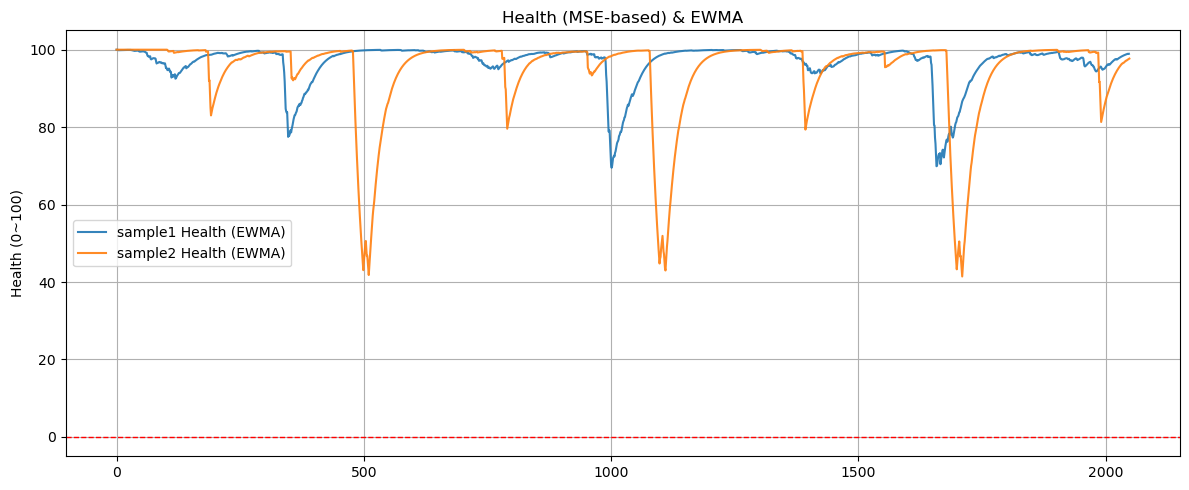

In [ ]:
나데히로: PM겸 리더 겸 HR, 회계경리, 교육, 이츠와리:실무, 데이터 분석 카즈마: 중위